# Example MSM.jl

This notebook shows how to use MSM. Our goal is to estimate the linear model using the Method of Simulated Moments (MSM). We observe a dependent variable $y_{t}$ and a set of independent variables $\boldsymbol{x_{1}}$, ..., $\boldsymbol{x_{t}}$, ... $\boldsymbol{x_{T}}$ and we want to estimate the intercept $\alpha$ and the slope coefficient $\boldsymbol{\beta}$ :

$$ y_{t} = \alpha + \boldsymbol{x_{t}}\boldsymbol{{\beta}} + e_{t} $$

where $e_{t}$ are error terms, potentially serially correlated. 

Here, it is clearly an overkill to use the MSM because we have a closed-form solution:

$$ \boldsymbol{\beta_{OLS}} = (X'X)^{-1}X'y $$

For the sake of this example, let's pretend we ignore the existence of this formula. By only simulating $y_{t}$, can we recover $\boldsymbol{{\beta}}$ and to inference on parameters?


## Step 0: Simulating data

Let's fix the value of $\boldsymbol{\beta} = \boldsymbol{\beta_{0}}$ and simulate a sample according to the linear model described above. Our goal is to recover the true value of $\boldsymbol{\beta}$ using moment conditions and simulated data.

In [1]:
using Distributions
using Random
Random.seed!(1234)  #for replicability reasons
T = 100000          #number of periods
P = 2               #number of dependent variables
beta0 = rand(P)     #choose true coefficients by drawing from a uniform distribution on [0,1]
alpha0 = rand(1)[]  #intercept
theta0 = 0.0        #coefficient to create serial correlation in the error terms
println("True intercept = $(alpha0)")
println("True coefficient beta0 = $(beta0)")
println("Serial correlation coefficient theta0 = $(theta0)")

# Generation of error terms
# row = individual dimension
# column = time dimension 
U = zeros(T)
d = Normal()
U[1] = rand(d, 1)[] #first error term
# loop over time periods
for t = 2:T
    U[t] = rand(d, 1)[] + theta0*U[t-1]
end

True intercept = 0.5662374165061859
True coefficient beta0 = [0.5908446386657102, 0.7667970365022592]
Serial correlation coefficient theta0 = 0.0


In [2]:
# Let's simulate the dependent variables x_t
x = zeros(T, P)

d = Uniform(0, 5)
for p = 1:P  
    x[:,p] = rand(d, T)
end

# Let's calculate the resulting y_t
y = zeros(T)

for t=1:T
    y[t] = alpha0 + x[t,1]*beta0[1] + x[t,2]*beta0[2] + U[t]
end

## Step 1: Initializing a MSMProblem

In [3]:
using MSM
using DataStructures
using OrderedCollections
using Random
using Distributions
using Statistics
using LinearAlgebra

# Here we set the maximum number of function evaluations to be 10000.
# We also select a global optimizer (see BlackBoxOptim.jl) and a local minimizer (see Optim.jl)
# https://github.com/robertfeldt/BlackBoxOptim.jl
# https://julianlsolvers.github.io/Optim.jl
myProblem = MSMProblem(options = MSMOptions(maxFuncEvals=10000, globalOptimizer = :dxnes, localOptimizer = :LBFGS));

In [4]:
dictEmpiricalMoments = OrderedDict{String,Array{Float64,1}}()
dictEmpiricalMoments["mean"] = [mean(y); mean(y)] #informative on the intercept
dictEmpiricalMoments["mean_x1y"] = [mean(x[:,1] .* y); mean(x[:,1] .* y)] #informative on betas
dictEmpiricalMoments["mean_x2y"] = [mean(x[:,2] .* y); mean(x[:,2] .* y)] #informative on betas
dictEmpiricalMoments["mean_x1y^2"] = [mean((x[:,1] .* y).^2); mean((x[:,1] .* y).^2)] #informative on betas
dictEmpiricalMoments["mean_x2y^2"] = [mean((x[:,2] .* y).^2); mean((x[:,2] .* y).^2)] #informative on betas

set_empirical_moments!(myProblem, dictEmpiricalMoments)

OrderedDict{String, Vector{Float64}} with 5 entries:
  "mean"       => [3.95288, 3.95288]
  "mean_x1y"   => [11.0611, 11.0611]
  "mean_x2y"   => [11.4634, 11.4634]
  "mean_x1y^2" => [203.361, 203.361]
  "mean_x2y^2" => [219.249, 219.249]

## Step 3. Set priors

One has to attach priors values the `MSMProblem` we are going to use.
This is achieved using the function  `set_priors!()`

In [5]:
dictPriors = OrderedDict{String,Array{Float64,1}}()
dictPriors["alpha"] = [0.5, 0.001, 1.0]
dictPriors["beta1"] = [0.5, 0.001, 1.0]
dictPriors["beta2"] = [0.5, 0.001, 1.0]

set_priors!(myProblem, dictPriors)

OrderedDict{String, Vector{Float64}} with 3 entries:
  "alpha" => [0.5, 0.001, 1.0]
  "beta1" => [0.5, 0.001, 1.0]
  "beta2" => [0.5, 0.001, 1.0]

## Step 4: Specifying the function generating simulated moments using parameter values

This is maybe the most crucial step. The objective function must generate an **ordered dictionary** containing the **keys of dictEmpiricalMoments**. Importantly, we "freeze" randomness during the minimization step. One way to do 
that is to generate draws from a Uniform([0,1]) outside of the objective function and to use [inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling) to generate draws from a normal distribution. Otherwise the objective function would be "noisy" and the minimization algorithms would have a hard time finding 
the global minimum. 

In [6]:
# x[1] corresponds to the intercept
# x[1] corresponds to beta1
# x[3] corresponds to beta2
function functionLinearModel(x; uniform_draws::Array{Float64,1}, simX::Array{Float64,2}, nbDraws::Int64 = length(uniform_draws), burnInPerc::Int64 = 10)
    T = nbDraws
    P = 2       #number of dependent variables

    alpha = x[1]
    beta = x[2:end]
    theta = 0.0     #coefficient to create serial correlation in the error terms

    # Creation of error terms
    # row = individual dimension
    # column = time dimension
    U = zeros(T)
    d = Normal()
    # Inverse cdf (i.e. quantile)
    gaussian_draws = quantile.(d, uniform_draws)
    U[1] = gaussian_draws[1] #first error term

    # loop over time periods
    for t = 2:T
        U[t] = gaussian_draws[t] + theta*U[t-1]
    end

    # Let's calculate the resulting y_t
    y = zeros(T)

    for t=1:T
        y[t] = alpha + simX[t,1]*beta[1] + simX[t,2]*beta[2] + U[t]
    end

    # Get rid of the burn-in phase:
    #------------------------------
    startT = div(nbDraws, burnInPerc)

    # Moments:
    #---------
    output = OrderedDict{String,Float64}()
    output["mean"] = mean(y[startT:nbDraws])
    output["mean_x1y"] = mean(simX[startT:nbDraws,1] .* y[startT:nbDraws])
    output["mean_x2y"] = mean(simX[startT:nbDraws,2] .* y[startT:nbDraws])
    output["mean_x1y^2"] = mean((simX[startT:nbDraws,1] .* y[startT:nbDraws]).^2)
    output["mean_x2y^2"] = mean((simX[startT:nbDraws,2] .* y[startT:nbDraws]).^2)

    return output
end

# Let's freeze the randomness during the minimization
d_Uni = Uniform(0,1)
nbDraws = 100000 #number of draws in the simulated data
uniform_draws = rand(d_Uni, nbDraws)
simX = zeros(length(uniform_draws), 2)
d = Uniform(0, 5)
for p = 1:2
  simX[:,p] = rand(d, length(uniform_draws))
end

set_simulate_empirical_moments!(myProblem, x -> functionLinearModel(x, uniform_draws = uniform_draws, simX = simX))

# Construct the objective function using:
#* the function: parameter -> simulated moments
#* emprical moments values
#* emprical moments weights
construct_objective_function!(myProblem)

(::MSM.var"#objective_function_percent#6"{MSMProblem}) (generic function with 1 method)

## Step 5. Running the optimization

In [7]:
# Global optimization:
msm_optimize!(myProblem, verbose = false)

hello


┌ Info: 1 worker(s) detected
└ @ MSM /home/julien/.julia/dev/MSM/src/generic.jl:302
┌ Info: Starting optimization in serial
└ @ MSM /home/julien/.julia/dev/MSM/src/generic.jl:302


Starting optimization with optimizer BlackBoxOptim.DXNESOpt{Float64, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
σ=1.0 η[x]=1.0 η[σ]=0.0 η[B]=0.0 |tr(ln_B)|=0.0 |path|=NaN speed=NaN
0.52 secs, 128 evals, 16 steps, fitness=0.000704811
σ=0.008863122430532163 η[x]=1.0 η[σ]=1.5714285714285714 η[B]=0.06349206349206349 |tr(ln_B)|=4.163336342344337e-17 |path|=NaN speed=NaN
1.05 secs, 208 evals, 26 steps, fitness=0.000072216
σ=0.004518606642367572 η[x]=1.0 η[σ]=1.5714285714285714 η[B]=0.06349206349206349 |tr(ln_B)|=6.938893903907228e-17 |path|=NaN speed=NaN
1.57 secs, 360 evals, 45 steps, fitness=0.000003947
σ=0.001013667165936197 η[x]=1.0 η[σ]=1.5714285714285714 η[B]=0.06349206349206349 |tr(ln_B)|=6.938893903907228e-17 |path|=NaN speed=NaN
2.09 secs, 512 evals, 64 steps, fitness=0.000003339
σ=9.91168140918459e-5 η[x]=1.0 η[σ]=1.5714285714285714 η[B]=0.06349206349206349 |tr(ln_B)|=2.7755575615628914e-17 |path|=NaN speed=NaN
2.59 secs, 664 eva

22.22 secs, 6112 evals, 764 steps, fitness=0.000000670
σ=6.015229034211146e-11 η[x]=1.0 η[σ]=1.5714285714285714 η[B]=0.06349206349206349 |tr(ln_B)|=1.5543122344752192e-15 |path|=NaN speed=NaN
22.75 secs, 6264 evals, 783 steps, fitness=0.000000670
σ=1.119248262886916e-11 η[x]=1.0 η[σ]=1.5714285714285714 η[B]=0.06349206349206349 |tr(ln_B)|=1.5543122344752192e-15 |path|=NaN speed=NaN
23.26 secs, 6408 evals, 801 steps, fitness=0.000000670
σ=1.494471960391964e-11 η[x]=1.0 η[σ]=1.5714285714285714 η[B]=0.06349206349206349 |tr(ln_B)|=1.887379141862766e-15 |path|=NaN speed=NaN
23.77 secs, 6552 evals, 819 steps, fitness=0.000000670
σ=3.4266516156335456e-11 η[x]=1.0 η[σ]=1.5714285714285714 η[B]=0.06349206349206349 |tr(ln_B)|=1.5543122344752192e-15 |path|=NaN speed=NaN
24.30 secs, 6688 evals, 836 steps, fitness=0.000000670
σ=5.719208675413216e-12 η[x]=1.0 η[σ]=1.5714285714285714 η[B]=0.06349206349206349 |tr(ln_B)|=1.1102230246251565e-15 |path|=NaN speed=NaN
24.84 secs, 6816 evals, 852 steps, fitne

(Any[6.700018003710311e-7], Any[[0.5714533006149943, 0.5830316604611774, 0.7672700012850744]])

## Step 6. Analysing Results

### A. Point estimates

In [10]:
minimizer = msm_minimizer(myProblem)
minimum_val = msm_minimum(myProblem)

println("Minimum objective function = $(minimum_val)")
println("Estimated value for alpha = $(minimizer[1]). True value for beta1 = $(alpha0[1]) \n")
println("Estimated value for beta1 = $(minimizer[2]). True value for beta1 = $(beta0[1]) \n")
println("Estimated value for beta2 = $(minimizer[3]). True value for beta2 = $(beta0[2]) \n")

Minimum objective function = 6.700018003710311e-7
Estimated value for alpha = 0.5714533006149943. True value for beta1 = 0.5662374165061859 

Estimated value for beta1 = 0.5830316604611774. True value for beta1 = 0.5908446386657102 

Estimated value for beta2 = 0.7672700012850744. True value for beta2 = 0.7667970365022592 



### B. Inference

### Estimation of the distance matrix $\Sigma_0$

Let's calculate the variance-covariance matrix of the "distance matrix" (using the terminolgy of [Duffie and Singleton (1993)](https://www.jstor.org/stable/2951768?seq=1)). Here we know that errors are not correlated (the serial correlation coefficient is set to 0 in the code above). in the presence of serial correlation, an HAC estimation would be needed (see the package [CovarianceMatrices](https://github.com/gragusa/CovarianceMatrices.jl) for instance)

In [9]:
# Empirical Series
#-----------------
X = zeros(T, 5)

X[:,1] = y
X[:,2] = (x[:,1] .* y)
X[:,3] = (x[:,2] .* y)
X[:,4] = (x[:,1] .* y).^2
X[:,5] = (x[:,2] .* y).^2

Sigma0 = cov(X)

5×5 Matrix{Float64}:
   2.942     12.1631    13.6279    346.754    392.581
  12.1631    81.0139    47.795    2369.6     1503.16
  13.6279    47.795     87.8405   1490.87    2622.29
 346.754   2369.6     1490.87    77664.1    50175.4
 392.581   1503.16    2622.29    50175.4    87292.2

### Asymptotic variance

The asymptotic variance of the MSM estimate is calculated using the usual GMM sandwich formula, corrected to take
into account simulation noise. See [Duffie and Singleton (1993)](https://www.jstor.org/stable/2951768?seq=1) and [Gouriéroux and Montfort (1996)](https://www.jstor.org/stable/3533164?seq=1). Calculating the 
asymptotic variance using MSM.jl is done in two steps:
* setting the value of of the distance matrix using the function `set_Sigma0!`
* calculating the asymptotic variance using the function `calculate_Avar!`

In [10]:
set_Sigma0!(myProblem, Sigma0)
calculate_Avar!(myProblem, minimizer, T, nbDraws) # nbDraws = number of draws in the simulated data

3×3 Symmetric{Float64, Matrix{Float64}}:
  63.4041   -11.7213   -8.66146
 -11.7213     6.80843  -2.14468
  -8.66146   -2.14468   5.87873

Once the asymptotic variance has been calculated, a summary table can be obtained using the
function `summary_table`. This function has four inputs:
* a MSMProblem
* the minimizer of the objective function
* the length of the empirical sample
* the confidence level associated to the test H0: $\theta_i = 0$, H1: $\theta_i != 0$

In [11]:
df = summary_table(myProblem, minimizer, T, 0.05)

,Estimate,StdError,tValue,pValue,ConfIntervalLower,ConfIntervalUpper
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.571453,0.0251802,22.6946,0.0,0.530036,0.612871
2,0.583032,0.00825132,70.6592,0.0,0.569459,0.596604
3,0.76727,0.00766729,100.071,0.0,0.754658,0.779882


### Comparison with OLS

Let's compare the MSM results to the one obtained using OLS:

In [12]:
using DataFrames, GLM
data = DataFrame(x1=x[:,1], x2=x[:,2], y= y[:]);

ols = lm(@formula(y ~ x1 + x2), data)

┌ Info: Precompiling GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1317


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x1 + x2

Coefficients:
─────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  0.571592  0.00836568   68.33    <1e-99   0.555196   0.587989
x1           0.588239  0.00218787  268.86    <1e-99   0.583951   0.592528
x2           0.767633  0.00219593  349.57    <1e-99   0.763329   0.771937
─────────────────────────────────────────────────────────────────────────

In terms of point estimates, MSM and OLS estimates are rather close. Regarding standard errors, the OLS estimates are more precisely estimated. This is not surprising given that simulation noise impacts the accuracy of the MSM estimate and that OLS uses much more information than MSM. 

### C. Slices of the objective function

One can "visually check" that the [local identification identification](https://en.wikipedia.org/wiki/Generalized_method_of_moments) is met by "slicing" the objective function. That is, we hold all the variables constant, and we calculate how the value of objective function changes when moving along one dimension. Hopefully, we will see nice U-shaped plots.

In [13]:
vXGrid, vYGrid = msm_slices(myProblem, minimizer, nbPoints = 7);

┌ Info: slicing along alpha
└ @ MSM /home/julien/.julia/dev/MSM/src/generic.jl:302
┌ Info: slicing along beta1
└ @ MSM /home/julien/.julia/dev/MSM/src/generic.jl:302
┌ Info: slicing along beta2
└ @ MSM /home/julien/.julia/dev/MSM/src/generic.jl:302


┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1317


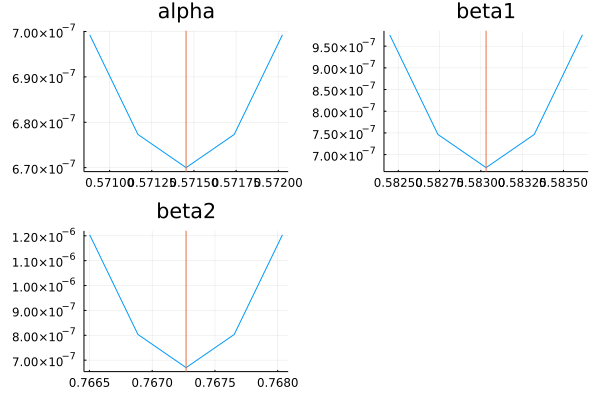

In [14]:
using Plots
gr()
list_plots = []
for (keyIndex, keyValue) in enumerate(keys(myProblem.priors))

  p = plot(vXGrid[:,keyIndex], vYGrid[:,keyIndex], title = "$(keyValue)", label = "")
  plot!([minimizer[keyIndex]], seriestype = :vline, label = "")
  push!(list_plots, p)

end

#Hacky way to combine all the plots in a single plot
s0 = ""
for i = 1:length(keys(myProblem.priors))
  if i==1
      s0 = string("list_plots[$(i)]" )
  else
      s0 = string(s0, ", ", "list_plots[$(i)]" )
  end
end

plot_combined = eval(Meta.parse(string("plot(", s0, ")")))
display(plot_combined)

## Appendix

In [15]:
versioninfo()

Julia Version 1.6.1
Commit 6aaedecc44 (2021-04-23 05:59 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)
